In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [22]:
# Load the dataset
df = pd.read_csv("healthcare_dataset.csv")
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [23]:
# Clean and preprocess
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.drop_duplicates(inplace=True)
string_cols = ['name', 'gender', 'blood_type', 'medical_condition', 'admission_type',
               'test_results', 'doctor', 'hospital', 'insurance_provider', 'medication']
for col in string_cols:
    df[col] = df[col].astype(str).str.strip().str.title()

df = df[df['billing_amount'] <= df['billing_amount'].quantile(0.99)]

In [24]:
# Age band feature
bins = [0, 20, 40, 60, 100]
labels = ['Teen', 'Adult', 'Midlife', 'Elderly']
df['age_band'] = pd.cut(df['age'], bins=bins, labels=labels)

# Classification: Predict 'test_results'
X = df[['age', 'gender', 'medical_condition', 'insurance_provider', 'admission_type', 'age_band']]
y = df['test_results']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
categorical_features = ['gender', 'medical_condition', 'insurance_provider', 'admission_type', 'age_band']
numeric_features = ['age']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])

In [25]:
# Decision Tree
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
dt_pipeline.fit(X_train, y_train)
dt_preds = dt_pipeline.predict(X_test)

In [26]:
# Naive Bayes
nb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])
nb_pipeline.fit(X_train, y_train)
nb_preds = nb_pipeline.predict(X_test)

In [27]:
# Hyperparameter tuning (Decision Tree)
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_dt_model = grid_search.best_estimator_
best_dt_preds = best_dt_model.predict(X_test)

In [28]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n--- {model_name} ---")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))

evaluate_model(y_test, dt_preds, "Decision Tree")


--- Decision Tree ---
Confusion Matrix:
 [[1679 1143  840]
 [1638 1109  838]
 [1699 1124  814]]

Classification Report:
               precision    recall  f1-score   support

    Abnormal       0.33      0.46      0.39      3662
Inconclusive       0.33      0.31      0.32      3585
      Normal       0.33      0.22      0.27      3637

    accuracy                           0.33     10884
   macro avg       0.33      0.33      0.32     10884
weighted avg       0.33      0.33      0.32     10884

Accuracy: 0.33094450569643513
F1 Score: 0.32390638091749463


In [29]:
evaluate_model(y_test, nb_preds, "Naive Bayes")


--- Naive Bayes ---
Confusion Matrix:
 [[1763  893 1006]
 [1693  872 1020]
 [1775  860 1002]]

Classification Report:
               precision    recall  f1-score   support

    Abnormal       0.34      0.48      0.40      3662
Inconclusive       0.33      0.24      0.28      3585
      Normal       0.33      0.28      0.30      3637

    accuracy                           0.33     10884
   macro avg       0.33      0.33      0.33     10884
weighted avg       0.33      0.33      0.33     10884

Accuracy: 0.33416023520764426
F1 Score: 0.3263790741745154


In [30]:
evaluate_model(y_test, best_dt_preds, "Tuned Decision Tree")



--- Tuned Decision Tree ---
Confusion Matrix:
 [[2463  752  447]
 [2423  705  457]
 [2469  691  477]]

Classification Report:
               precision    recall  f1-score   support

    Abnormal       0.33      0.67      0.45      3662
Inconclusive       0.33      0.20      0.25      3585
      Normal       0.35      0.13      0.19      3637

    accuracy                           0.33     10884
   macro avg       0.34      0.33      0.29     10884
weighted avg       0.34      0.33      0.29     10884

Accuracy: 0.3348952590959206
F1 Score: 0.29497806050842323


In [31]:
# ROC Curve (binary classes only)
if len(y.unique()) == 2:
    y_probs = best_dt_model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test.map({'Normal': 0, 'Abnormal': 1}), y_probs[:, 1])
    plt.plot(fpr, tpr, label="Tuned Decision Tree")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Clustering with KMeans
cluster_data = df[['age', 'billing_amount']]
cluster_scaled = StandardScaler().fit_transform(cluster_data)

In [32]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(cluster_scaled)

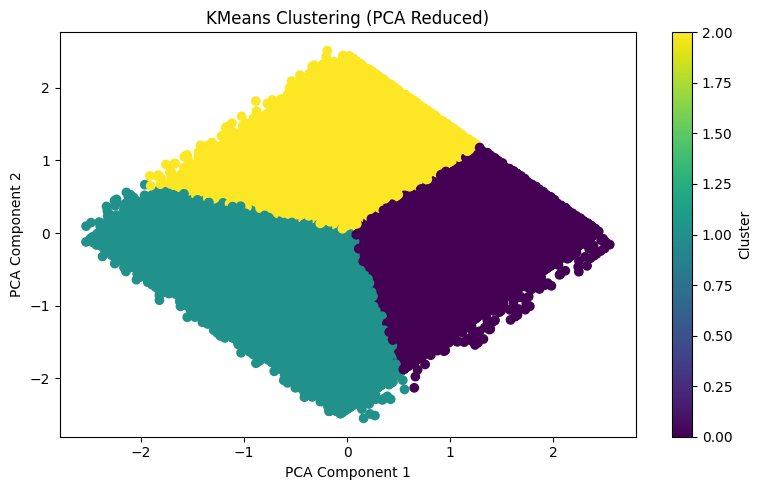

In [33]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(cluster_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('KMeans Clustering (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

In [34]:
# Association Rule Mining
basket = df[['medical_condition', 'medication']].dropna().values.tolist()
te = TransactionEncoder()
basket_te = te.fit_transform(basket)
df_basket = pd.DataFrame(basket_te, columns=te.columns_)

frequent_items = apriori(df_basket, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_items, metric="lift", min_threshold=0.5)

# Show top 10 rules sorted by confidence
rules.sort_values(by='confidence', ascending=False, inplace=True)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))



       antecedents    consequents   support  confidence      lift
31        (Cancer)      (Lipitor)  0.034659    0.208513  1.036394
25        (Asthma)  (Paracetamol)  0.034181    0.206277  1.032828
1      (Arthritis)      (Aspirin)  0.034347    0.205227  1.027853
59       (Obesity)   (Penicillin)  0.034108    0.204811  1.028897
44  (Hypertension)    (Ibuprofen)  0.034034    0.204505  1.020670
39      (Diabetes)      (Lipitor)  0.034200    0.203856  1.013246
29        (Cancer)    (Ibuprofen)  0.033777    0.203206  1.014186
19       (Obesity)      (Aspirin)  0.033758    0.202715  1.015271
7      (Arthritis)  (Paracetamol)  0.033850    0.202262  1.012724
43      (Diabetes)   (Penicillin)  0.033887    0.201994  1.014742
